In [706]:
# Import standard library
import numpy as np
import pandas as pd

from statsmodels.stats.proportion import power_proportions_2indep, test_proportions_2indep
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [707]:
# Import data

abtest_landingpage = pd.read_csv("ab.csv", index_col=0, parse_dates=True)
abtest_landingpage 

,timestamp,group,landing_page,converted
user_id,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0
804228,2017-01-12 08:01:45.159739,control,old_page,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0
864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...
751197,2017-01-03 22:28:38.630509,control,old_page,0
945152,2017-01-12 00:51:57.078372,control,old_page,0
734608,2017-01-22 11:45:03.439544,control,old_page,0


In [708]:
# Checking data types

abtest_landingpage.dtypes

timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [709]:
# Parsing timestamp from string into datetime format

abtest_landingpage['timestamp'] = pd.to_datetime(abtest_landingpage['timestamp'], 
                                                 format='%Y-%m-%d %H:%M:%S.%f')

In [710]:
abtest_landingpage.dtypes

timestamp       datetime64[ns]
group                   object
landing_page            object
converted                int64
dtype: object

In [711]:
# Index reset

abtest_landingpage = abtest_landingpage.reset_index()

In [712]:
abtest_landingpage

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [713]:
# Checking the earliest timestamp

first_visit = abtest_landingpage['timestamp'].min()
first_visit

Timestamp('2017-01-02 13:42:05.378582')

In [714]:
# Checking the last timestamp

last_visit = abtest_landingpage['timestamp'].max()
last_visit

Timestamp('2017-01-24 13:41:54.460509')

In [715]:
# Calculating the period of this testing

period = last_visit - first_visit
print(period)

21 days 23:59:49.081927


## Data Cleaning

### 1. Remove duplicates based on user_id

In [716]:
# Show all duplicated rows

abtest_landingpage[abtest_landingpage.duplicated(['user_id'], keep=False)].sort_values(by=["user_id"])

,user_id,timestamp,group,landing_page,converted
230259,630052,2017-01-17 01:16:05.208766,treatment,new_page,0
213114,630052,2017-01-07 12:25:54.089486,treatment,old_page,1
22513,630126,2017-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2017-01-19 17:16:00.280440,treatment,new_page,0
183371,630137,2017-01-20 02:08:49.893878,control,old_page,0
...,...,...,...,...,...
142354,945703,2017-01-08 19:40:51.169351,control,new_page,0
186960,945797,2017-01-13 17:23:21.750962,control,old_page,0
40370,945797,2017-01-11 03:04:49.433736,control,new_page,1
165143,945971,2017-01-16 10:09:18.383183,control,old_page,0


In [717]:
# Drop all duplicated rows

abtest_landingpage = abtest_landingpage.drop_duplicates(subset=['user_id'])
abtest_landingpage

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [718]:
# Recheck if duplicates are still there

abtest_landingpage[abtest_landingpage.duplicated(['user_id'], keep=False)].sort_values(by=["user_id"])

# No more duplicates!

,user_id,timestamp,group,landing_page,converted


### 2. Check for any NaN values

In [719]:
abtest_landingpage.isnull().values.any()

# No null values. All clear!

False

## 1. Penyusunan hipotesis

$H_0$: Rata-rata conversion rate kedua landing page sama saja, $ \mu_A = \mu_B $

$H_1$: Rata-rata conversion rate landing page lama (control) berbeda dengan rata-rata conversion rate landing page baru (treatment), $ \mu_A ≠ \mu_B $

## 2. Melakukan preanalysis

Kita akan menghitung Relative Effect Size dengan Power sebesar 80%.

In [720]:
# Dataset summary 

abtest_landingpage_summary = abtest_landingpage.describe().reset_index().copy()
abtest_landingpage_summary

,index,user_id,converted
0,count,290584.000000,290584.000000
1,mean,788004.876222,0.119570
2,std,91224.735468,0.324458
3,min,630000.000000,0.000000
4,25%,709034.750000,0.000000
5,50%,787995.500000,0.000000
6,75%,866956.250000,0.000000
7,max,945999.000000,1.000000


In [721]:
# Checking the total number of traffics

num_traffic = len(abtest_landingpage)
num_traffic

290584

In [722]:
# Defining the control group's proportion

n_controlgroup = len(abtest_landingpage[abtest_landingpage['landing_page']=='old_page'])
print("Number of control group data =",n_controlgroup)
print("Proportion of control group data=", n_controlgroup/len(abtest_landingpage))

Number of control group data = 145264
Proportion of control group data= 0.49990364232029294


In [723]:
# Defining the treatment group's proportion

n_treatmentgroup = len(abtest_landingpage[abtest_landingpage['landing_page']=='new_page'])
print("Number of treament group data =",n_treatmentgroup)
print("Proportion of treatment group data=", n_treatmentgroup/len(abtest_landingpage))

Number of treament group data = 145320
Proportion of treatment group data= 0.5000963576797071


In [753]:
# Calculating the test's effect size

sample_size = n_treatmentgroup
test_split = 0.5 # persentase traffic yang dialokasikan ke treatment group

effect_size = tt_ind_solve_power(power=0.8,
                                 nobs1=sample_size,
                                 ratio=(1-test_split)/test_split,
                                 alpha=0.01, # agar lebih akurat
                                 alternative="two-sided") 

print(effect_size)

0.012678611710024662


In [728]:
# Calculating the test's absolute effect size

absolute_effect_size = effect_size * abtest_landingpage_summary['converted'][2]


print(absolute_effect_size)

0.004113222385388773


In [729]:
# Calculating the test's relative effect size

relative_effect_size = absolute_effect_size / abtest_landingpage_summary['converted'][1]


print(relative_effect_size)

0.034400247910082345


Dapat disimpulkan bahwa adanya perbedaan rata-rata conversion sebesar 3.44% selama 21 hari 23 jam 59 menit 49 detik dapat dideteksi dalam eksperimen ini dengan 290.584 traffic dan power sebesar 80%.

## 3. Menganalisis Hasil Tes (Rerata)


In [730]:
# Agregasi untuk melihat conversion rate

abtest_landingpage_result = abtest_landingpage.groupby("group").agg({"converted":['count','sum']}).reset_index().values
df_abtest_landingpage_result = pd.DataFrame(abtest_landingpage_result,columns = ["group","visit","sales"] )
df_abtest_landingpage_result["conversion_rate"] = df_abtest_landingpage_result["sales"]/df_abtest_landingpage_result["visit"]
df_abtest_landingpage_result

,group,visit,sales,conversion_rate
0,control,145232,17471,0.120297
1,treatment,145352,17274,0.118843


In [731]:
# Creating dataframes to later include the testing result

df_abtest_landingpage_result_treatment = df_abtest_landingpage_result.query('group == "treatment"')
df_abtest_landingpage_result_treatment = df_abtest_landingpage_result_treatment.drop('group', axis=1)
df_abtest_landingpage_result_treatment.columns = ["visit_1","sales_1","conversion_rate_1"]

df_abtest_landingpage_result_control = df_abtest_landingpage_result.query('group == "control"')
df_abtest_landingpage_result_control = df_abtest_landingpage_result_control.drop('group', axis=1)
df_abtest_landingpage_result_control.columns = ["visit_0","sales_0","conversion_rate_0"]

average = ['average']
df_abtest_landingpage_result_treatment['category'] = average
df_abtest_landingpage_result_control['category'] = average

In [732]:
# Merge both dataframes

df_abtest_landingpage_result = pd.merge(df_abtest_landingpage_result_treatment,df_abtest_landingpage_result_control,on="category")
df_abtest_landingpage_result = df_abtest_landingpage_result[['category', 'visit_0', 'sales_0', 'conversion_rate_0','visit_1','sales_1','conversion_rate_1']]
df_abtest_landingpage_result

,category,visit_0,sales_0,conversion_rate_0,visit_1,sales_1,conversion_rate_1
0,average,145232,17471,0.120297,145352,17274,0.118843


In [733]:
# Hypothesis testing

analysis_abtest_landingpage_result_2 = test_proportions_2indep(count1=df_abtest_landingpage_result["sales_1"][0], 
                                                               nobs1=df_abtest_landingpage_result["visit_1"][0], 
                                                               count2=df_abtest_landingpage_result["sales_0"][0],
                                                               nobs2=df_abtest_landingpage_result["visit_0"][0],
                                                               alternative="two-sided")
print(analysis_abtest_landingpage_result_2)

statistic = -1.2083574960915626
pvalue = 0.22690978142806528
compare = diff
method = agresti-caffo
diff = -0.001454645698457463
ratio = 0.9879078985702952
odds_ratio = 0.9862770255078118
variance = 1.4491528627659845e-06
alternative = two-sided
value = 0
tuple = (-1.2083574960915626, 0.22690978142806528)


In [734]:
# Inputting hypothesis testing into the dataframe

df_abtest_landingpage_result['p_value'] = test_proportions_2indep(count1=df_abtest_landingpage_result["sales_1"][0], 
                                                               nobs1=df_abtest_landingpage_result["visit_1"][0], 
                                                               count2=df_abtest_landingpage_result["sales_0"][0],
                                                               nobs2=df_abtest_landingpage_result["visit_0"][0],
                                                               alternative="two-sided")[1]
df_abtest_landingpage_result

,category,visit_0,sales_0,conversion_rate_0,visit_1,sales_1,conversion_rate_1,p_value
0,average,145232,17471,0.120297,145352,17274,0.118843,0.22691


In [735]:
# Saving the dataframe into an xlsx file

df_abtest_landingpage_result.to_excel("AB_test_average.xlsx")

### Kesimpulan

p-value = 0.108

alpha (significance level) = 0.01

> Rata-rata conversion rate kedua landing page memiliki sedikit perbedaan. Varian tes (landing page baru) memiliki conversion rate sebesar 11.89% dan mengalami penurunan sebanyak 1.65% dari varian kontrol (landing page lama) yang memiliki conversion rate sebesar 12.03%.

Mengetahui bahwa pvalue > 0.01 (angka significance level yang dipilih), maka kita gagal menolak $H_0$. Artinya, tidak terdapat cukup bukti untuk mengatakan adanya perbedaan, baik positif maupun negatif, pada rerata conversion rate dari landing page baru terhadap landing page lama. Berdasarkan hasil tersebut, keputusan bisnis yang cenderung diambil adalah untuk tetap terapkan landing page lama.


## 4. Menganalisis Hasil Tes (Harian)


In [736]:
# Sort data by timestamp 
abtest_landingpage = abtest_landingpage.sort_values('timestamp')

In [737]:
abtest_landingpage

,user_id,timestamp,group,landing_page,converted
131228,922696,2017-01-02 13:42:05.378582,treatment,new_page,0
184884,781507,2017-01-02 13:42:15.234051,control,old_page,0
83878,737319,2017-01-02 13:42:21.786186,control,old_page,0
102717,818377,2017-01-02 13:42:26.640581,treatment,new_page,0
158789,725857,2017-01-02 13:42:27.851110,treatment,new_page,0
...,...,...,...,...,...
153305,851645,2017-01-24 13:41:18.869978,treatment,old_page,0
47535,808330,2017-01-24 13:41:19.152664,control,old_page,0
157787,843121,2017-01-24 13:41:44.097174,treatment,new_page,0
179072,836373,2017-01-24 13:41:52.604673,control,old_page,0


In [738]:
# Separate date & time into different columns

abtest_landingpage['date'] = abtest_landingpage['timestamp'].dt.date
abtest_landingpage['time'] = abtest_landingpage['timestamp'].dt.time

In [739]:
abtest_landingpage

,user_id,timestamp,group,landing_page,converted,date,time
131228,922696,2017-01-02 13:42:05.378582,treatment,new_page,0,2017-01-02,13:42:05.378582
184884,781507,2017-01-02 13:42:15.234051,control,old_page,0,2017-01-02,13:42:15.234051
83878,737319,2017-01-02 13:42:21.786186,control,old_page,0,2017-01-02,13:42:21.786186
102717,818377,2017-01-02 13:42:26.640581,treatment,new_page,0,2017-01-02,13:42:26.640581
158789,725857,2017-01-02 13:42:27.851110,treatment,new_page,0,2017-01-02,13:42:27.851110
...,...,...,...,...,...,...,...
153305,851645,2017-01-24 13:41:18.869978,treatment,old_page,0,2017-01-24,13:41:18.869978
47535,808330,2017-01-24 13:41:19.152664,control,old_page,0,2017-01-24,13:41:19.152664
157787,843121,2017-01-24 13:41:44.097174,treatment,new_page,0,2017-01-24,13:41:44.097174
179072,836373,2017-01-24 13:41:52.604673,control,old_page,0,2017-01-24,13:41:52.604673


In [740]:
# Create a dataframe for the control group

abtest_landingpage_control = abtest_landingpage.query('group == "control"')
abtest_landingpage_control

,user_id,timestamp,group,landing_page,converted,date,time
184884,781507,2017-01-02 13:42:15.234051,control,old_page,0,2017-01-02,13:42:15.234051
83878,737319,2017-01-02 13:42:21.786186,control,old_page,0,2017-01-02,13:42:21.786186
112584,799109,2017-01-02 13:42:45.219901,control,old_page,0,2017-01-02,13:42:45.219901
126997,643921,2017-01-02 13:43:03.767329,control,old_page,1,2017-01-02,13:43:03.767329
189698,677659,2017-01-02 13:43:32.744957,control,old_page,0,2017-01-02,13:43:32.744957
...,...,...,...,...,...,...,...
260161,712000,2017-01-24 13:40:54.479759,control,old_page,1,2017-01-24,13:40:54.479759
180924,808180,2017-01-24 13:41:07.867394,control,old_page,0,2017-01-24,13:41:07.867394
47535,808330,2017-01-24 13:41:19.152664,control,old_page,0,2017-01-24,13:41:19.152664
179072,836373,2017-01-24 13:41:52.604673,control,old_page,0,2017-01-24,13:41:52.604673


In [741]:
# Calculate daily conversion rate for the control group

abtest_landingpage_control_result = abtest_landingpage_control.groupby("date").agg({"converted":['count','sum']}).reset_index().values
df_abtest_landingpage_control_result_daily = pd.DataFrame(abtest_landingpage_control_result,columns = ["date","visit_0","sales_0"] )
df_abtest_landingpage_control_result_daily["conversion_rate_0"] = df_abtest_landingpage_control_result_daily["sales_0"]/df_abtest_landingpage_control_result_daily["visit_0"]
df_abtest_landingpage_control_result_daily

,date,visit_0,sales_0,conversion_rate_0
0,2017-01-02,2843,355,0.124868
1,2017-01-03,6595,751,0.113874
2,2017-01-04,6565,800,0.121858
3,2017-01-05,6429,791,0.123036
4,2017-01-06,6609,769,0.116356
5,2017-01-07,6587,793,0.120389
6,2017-01-08,6677,795,0.119065
7,2017-01-09,6624,788,0.118961
8,2017-01-10,6660,757,0.113664
9,2017-01-11,6698,794,0.118543


In [742]:
# Create a dataframe for the treatment group

abtest_landingpage_treatment = abtest_landingpage.query('group == "treatment"')
abtest_landingpage_treatment

,user_id,timestamp,group,landing_page,converted,date,time
131228,922696,2017-01-02 13:42:05.378582,treatment,new_page,0,2017-01-02,13:42:05.378582
102717,818377,2017-01-02 13:42:26.640581,treatment,new_page,0,2017-01-02,13:42:26.640581
158789,725857,2017-01-02 13:42:27.851110,treatment,new_page,0,2017-01-02,13:42:27.851110
191378,762651,2017-01-02 13:42:28.522322,treatment,new_page,0,2017-01-02,13:42:28.522322
111830,722516,2017-01-02 13:42:34.033708,treatment,new_page,0,2017-01-02,13:42:34.033708
...,...,...,...,...,...,...,...
225633,735831,2017-01-24 13:40:20.250510,treatment,new_page,0,2017-01-24,13:40:20.250510
29690,787704,2017-01-24 13:41:04.416938,treatment,new_page,0,2017-01-24,13:41:04.416938
158814,799244,2017-01-24 13:41:15.325359,treatment,new_page,0,2017-01-24,13:41:15.325359
153305,851645,2017-01-24 13:41:18.869978,treatment,old_page,0,2017-01-24,13:41:18.869978


In [744]:
# Calculate daily conversion rate for the treatment group

abtest_landingpage_treatment_result = abtest_landingpage_treatment.groupby("date").agg({"converted":['count','sum']}).reset_index().values
df_abtest_landingpage_result_treatment_daily = pd.DataFrame(abtest_landingpage_treatment_result,columns = ["date","visit_1","sales_1"] )
df_abtest_landingpage_result_treatment_daily["conversion_rate_1"] = df_abtest_landingpage_result_treatment_daily["sales_1"]/df_abtest_landingpage_result_treatment_daily["visit_1"]
df_abtest_landingpage_result_treatment_daily

,date,visit_1,sales_1,conversion_rate_1
0,2017-01-02,2855,342,0.11979
1,2017-01-03,6625,751,0.113358
2,2017-01-04,6541,763,0.116649
3,2017-01-05,6491,744,0.11462
4,2017-01-06,6743,834,0.123684
5,2017-01-07,6612,768,0.116152
6,2017-01-08,6710,814,0.121311
7,2017-01-09,6624,785,0.118508
8,2017-01-10,6684,850,0.127169
9,2017-01-11,6683,775,0.115966


In [745]:
# Merge both dataframes

df_abtest_landingpage_result_daily = pd.merge(df_abtest_landingpage_control_result_daily,df_abtest_landingpage_result_treatment_daily,on="date")
df_abtest_landingpage_result_daily

,date,visit_0,sales_0,conversion_rate_0,visit_1,sales_1,conversion_rate_1
0,2017-01-02,2843,355,0.124868,2855,342,0.11979
1,2017-01-03,6595,751,0.113874,6625,751,0.113358
2,2017-01-04,6565,800,0.121858,6541,763,0.116649
3,2017-01-05,6429,791,0.123036,6491,744,0.11462
4,2017-01-06,6609,769,0.116356,6743,834,0.123684
5,2017-01-07,6587,793,0.120389,6612,768,0.116152
6,2017-01-08,6677,795,0.119065,6710,814,0.121311
7,2017-01-09,6624,788,0.118961,6624,785,0.118508
8,2017-01-10,6660,757,0.113664,6684,850,0.127169
9,2017-01-11,6698,794,0.118543,6683,775,0.115966


In [746]:
# Changing visit & sales column data types into float so it can be processed in the hypothesis testing

df_abtest_landingpage_result_daily['visit_0'] = df_abtest_landingpage_result_daily['visit_0'].values.astype(float)
df_abtest_landingpage_result_daily['sales_0'] = df_abtest_landingpage_result_daily['sales_0'].values.astype(float)
df_abtest_landingpage_result_daily['visit_1'] = df_abtest_landingpage_result_daily['visit_1'].values.astype(float)
df_abtest_landingpage_result_daily['sales_1'] = df_abtest_landingpage_result_daily['sales_1'].values.astype(float)

In [747]:
# Hypothesis testing

df_abtest_landingpage_result_daily['p_value'] = test_proportions_2indep(count1 = df_abtest_landingpage_result_daily["sales_1"],
                                                                        nobs1= df_abtest_landingpage_result_daily["visit_1"],
                                                                        count2=df_abtest_landingpage_result_daily["sales_0"],
                                                                        nobs2=df_abtest_landingpage_result_daily["visit_0"],
                                                                        alternative="two-sided")[1] # larger because we're checking if the landing page B results in higher CVR
df_abtest_landingpage_result_daily

,date,visit_0,sales_0,conversion_rate_0,visit_1,sales_1,conversion_rate_1,p_value
0,2017-01-02,2843.0,355.0,0.124868,2855.0,342.0,0.11979,0.558999
1,2017-01-03,6595.0,751.0,0.113874,6625.0,751.0,0.113358,0.925543
2,2017-01-04,6565.0,800.0,0.121858,6541.0,763.0,0.116649,0.357806
3,2017-01-05,6429.0,791.0,0.123036,6491.0,744.0,0.11462,0.139547
4,2017-01-06,6609.0,769.0,0.116356,6743.0,834.0,0.123684,0.193019
5,2017-01-07,6587.0,793.0,0.120389,6612.0,768.0,0.116152,0.451332
6,2017-01-08,6677.0,795.0,0.119065,6710.0,814.0,0.121311,0.689701
7,2017-01-09,6624.0,788.0,0.118961,6624.0,785.0,0.118508,0.935816
8,2017-01-10,6660.0,757.0,0.113664,6684.0,850.0,0.127169,0.016571
9,2017-01-11,6698.0,794.0,0.118543,6683.0,775.0,0.115966,0.643385


<AxesSubplot:xlabel='date'>

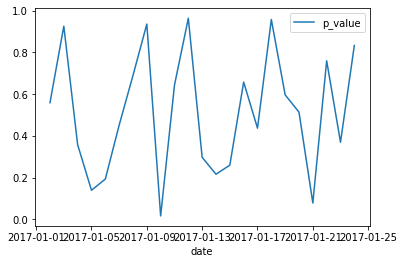

In [748]:
df_abtest_landingpage_result_daily.plot("date","p_value")

In [749]:
# Saving the dataframe into an xlsx file

df_abtest_landingpage_result_daily.to_excel("AB_test_daily.xlsx")

In [750]:
# Saving the original file into an xlsx file, just in case it's needed

read_file = pd.read_csv("ab.csv", index_col=0, parse_dates=True)

excel = pd.ExcelWriter('ab.xlsx')
read_file.to_excel(excel,index = False)

excel.save()

# Fin!